# Preliminary Multiomic Analysis
The aim here is a preliminary multiomic analysis of the transcriptomic and microbiomic datasets, the aim is to process this all so we can input the data into graphia and plot the clusters found.
This builds on work from
* [ml_transform_rnaseq.ipynb](ml_transform_rnaseq.ipynb)
* [ml_transform_microbiome.ipynb](ml_transform_microbiome.ipynb)

## Libraries and Configs

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

## Transcriptomic data
Load in the top 1000 variable data (./data/outputs/rnaseq/high_variance_ln_transcript.csv). Then standardise to the sham pigs 1-4 but exclude Pig 4 as it has weird behaviour.

### Load Data

In [2]:
# Load data
high_var_ln_transcriptomic = pd.read_csv("./data/outputs/rnaseq/high_variance_ln_transcript.csv")
#Set the Gene column as the index
high_var_ln_transcriptomic.set_index('gene', inplace=True)
display(high_var_ln_transcriptomic.head())

# Load metadata to identify control (Sham) samples
metadata_df = pd.read_csv("./data/metadata.csv")
metadata_df.rename(columns={'Pig ': 'Pig'}, inplace=True)  # Fix spaces if needed
metadata_df['Pig'] = metadata_df['Pig'].astype(str)
metadata_df['Pig'] = metadata_df['Pig'].apply(lambda x: f'PIG{x}')  # Match RNA-seq names

# Identify control (Sham) sample columns
sham_samples = metadata_df[metadata_df['Treatment'] == "Sham"]['Pig'].tolist()
sham_samples = sham_samples[:3]  # Only use first 3 Sham samples because PIG4 is sick

,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
gene,,,,,,,,,,,,
ENSSSCG00000011875,8.502486,8.470521,8.660081,5.926926,8.509766,7.904704,4.442651,2.772589,3.295837,1.098612,5.068904,0.000000
ENSSSCG00000032857,0.000000,0.000000,0.000000,8.017308,2.564949,2.564949,7.260523,5.605802,3.178054,4.290459,2.890372,5.068904
ENSSSCG00000003145,6.647688,3.044522,1.386294,5.342334,3.258097,8.619208,3.332205,2.772589,2.197225,8.330623,8.592857,2.833213
ENSSSCG00000006932,11.010580,10.243632,9.102978,8.759355,10.582561,9.760079,6.431331,6.142037,4.465908,5.010635,4.634729,3.891820
ENSSSCG00000014987,3.295837,3.135494,0.693147,0.693147,5.484797,4.912655,9.408945,7.859799,4.110874,6.731018,5.846439,6.504288


### Z-score

In [3]:
# Compute mean & std of control (Sham) samples per gene
sham_mean = high_var_ln_transcriptomic[sham_samples].mean(axis=1)
sham_std = high_var_ln_transcriptomic[sham_samples].std(axis=1)

# Avoid division by zero by replacing 0 std with a small value (e.g., 1e-6)
sham_std_safe = sham_std.replace(0, 1e-6)

# Compute Z-scores safely (expression relative to Sham)
z_score_df = (high_var_ln_transcriptomic - sham_mean.values.reshape(-1, 1)) / sham_std_safe.values.reshape(-1, 1)
z_score_df = z_score_df.fillna(0)  # Fill NaN values with 0

z_score_df.to_csv("./data/outputs/rnaseq/z_score_ln_transcript_filtered.csv")


### Heatmap for visualisation

In [4]:
# Perform hierarchical clustering on genes (rows)
row_linkage = sch.linkage(dist.pdist(z_score_df, metric="euclidean"), method="ward")
row_dendro = sch.dendrogram(row_linkage, no_plot=True)
row_order = row_dendro['leaves']

# Perform hierarchical clustering on samples (columns)
col_linkage = sch.linkage(dist.pdist(z_score_df.T, metric="euclidean"), method="ward")
col_dendro = sch.dendrogram(col_linkage, no_plot=True)
col_order = col_dendro['leaves']
display(z_score_df.describe())
# Reorder the dataframe based on clustering results
clustered_df = z_score_df.iloc[row_order, :]

# Create an interactive heatmap
fig = px.imshow(
    clustered_df, 
    labels=dict(x="Samples", y="Genes", color="Expression Level"),
    color_continuous_scale="RdBu_r",  # Blue = low, Red = high expression
    zmin=-9, zmax=9,  # Adjust this range if needed for better visualization
    aspect="auto"
)

fig.update_layout(
    title="Hierarchical Clustering Heatmap (Plotly)",
    xaxis_title="Samples",
    yaxis_title="Genes",
    width=1000,
    height=800
)

fig.show()

,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,0.082215,-0.255789,0.173575,5.803595e+04,1.477862e+04,3.151399e+04,6.727621e+04,5.615767e+04,4.243832e+04,5.090753e+04,3.596491e+04,5.146409e+04
std,0.777567,0.761821,0.812741,5.291183e+05,2.017104e+05,2.983664e+05,5.142871e+05,4.393616e+05,3.678219e+05,3.873155e+05,3.048615e+05,4.130443e+05
min,-1.154701,-1.154701,-1.154701,-1.018965e+02,-4.192682e+01,-2.979432e+01,-6.934752e+01,-5.687515e+01,-5.171906e+01,-7.337054e+01,-3.424722e+01,-8.419629e+01
25%,-0.577350,-1.024192,-0.577350,-2.341534e+00,-1.034671e+00,-1.261425e+00,-3.095757e+00,-1.763185e+00,-3.224075e+00,-3.038760e+00,-1.903405e+00,-1.760475e+00
50%,0.223966,-0.381356,0.395399,-5.773503e-01,-3.732738e-02,-5.216448e-02,-6.078191e-01,-2.695468e-01,-1.106451e+00,-9.513733e-01,-2.868072e-01,-2.593327e-01
75%,0.764038,0.396351,0.910990,1.356004e+00,7.692382e-01,1.070350e+00,1.159173e+00,1.333364e+00,6.335267e-01,8.894679e-01,1.080921e+00,1.274028e+00
max,1.154701,1.154701,1.154701,8.017308e+06,4.317488e+06,4.043051e+06,7.260523e+06,5.605802e+06,5.093750e+06,4.290459e+06,3.806662e+06,5.068904e+06


### Heatmap no PIG4

In [5]:
remove_PG4 = z_score_df.drop(columns=['PIG4'])
# Perform hierarchical clustering on genes (rows)
row_linkage = sch.linkage(dist.pdist(remove_PG4, metric="euclidean"), method="ward")
row_dendro = sch.dendrogram(row_linkage, no_plot=True)
row_order = row_dendro['leaves']

# Perform hierarchical clustering on samples (columns)
col_linkage = sch.linkage(dist.pdist(remove_PG4.T, metric="euclidean"), method="ward")
col_dendro = sch.dendrogram(col_linkage, no_plot=True)
col_order = col_dendro['leaves']
display(z_score_df.describe())
# Reorder the dataframe based on clustering results
clustered_df = remove_PG4.iloc[row_order, :]

# Create an interactive heatmap
fig = px.imshow(
    clustered_df, 
    labels=dict(x="Samples", y="Genes", color="Expression Level"),
    color_continuous_scale="RdBu_r",  # Blue = low, Red = high expression
    zmin=-9, zmax=9,  # Adjust this range if needed for better visualization
    aspect="auto"
)

fig.update_layout(
    title="Hierarchical Clustering Heatmap (Plotly)",
    xaxis_title="Samples",
    yaxis_title="Genes",
    width=1000,
    height=800
)

fig.show()

,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,0.082215,-0.255789,0.173575,5.803595e+04,1.477862e+04,3.151399e+04,6.727621e+04,5.615767e+04,4.243832e+04,5.090753e+04,3.596491e+04,5.146409e+04
std,0.777567,0.761821,0.812741,5.291183e+05,2.017104e+05,2.983664e+05,5.142871e+05,4.393616e+05,3.678219e+05,3.873155e+05,3.048615e+05,4.130443e+05
min,-1.154701,-1.154701,-1.154701,-1.018965e+02,-4.192682e+01,-2.979432e+01,-6.934752e+01,-5.687515e+01,-5.171906e+01,-7.337054e+01,-3.424722e+01,-8.419629e+01
25%,-0.577350,-1.024192,-0.577350,-2.341534e+00,-1.034671e+00,-1.261425e+00,-3.095757e+00,-1.763185e+00,-3.224075e+00,-3.038760e+00,-1.903405e+00,-1.760475e+00
50%,0.223966,-0.381356,0.395399,-5.773503e-01,-3.732738e-02,-5.216448e-02,-6.078191e-01,-2.695468e-01,-1.106451e+00,-9.513733e-01,-2.868072e-01,-2.593327e-01
75%,0.764038,0.396351,0.910990,1.356004e+00,7.692382e-01,1.070350e+00,1.159173e+00,1.333364e+00,6.335267e-01,8.894679e-01,1.080921e+00,1.274028e+00
max,1.154701,1.154701,1.154701,8.017308e+06,4.317488e+06,4.043051e+06,7.260523e+06,5.605802e+06,5.093750e+06,4.290459e+06,3.806662e+06,5.068904e+06


## Load microbiomic data

In [6]:
clr_sham_normalised_df = pd.read_csv("./data/outputs/microbiome/simplified_microbiome_clr_sham_normalised.csv")
clr_sham_normalised_df

,Kingdom,Phylum,Class,Order,Family,Genus,PIG1,PIG2,PIG3,PIG4,PIG5,PIG6,PIG7,PIG8,PIG9,PIG10,PIG11,PIG12
0,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,5.712125,-12.822773,3.214027,3.896622,-12.485928,-11.985055,1.950571,-7.293887,0.393945,2.563876,-0.498228,2.168895
1,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanosphaera,-12.785886,2.986584,4.314428,5.484874,5.765457,7.508467,6.165398,10.453738,5.349650,6.316346,2.914325,6.519345
2,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,-2.980137,-2.566300,8.441374,-2.894937,-2.229455,-1.728582,10.597607,2.962586,11.033410,-1.492345,-3.370694,9.940467
3,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Aeriscardovia,0.119737,0.533575,-0.858250,0.204938,0.870419,1.371293,0.342435,6.062461,0.183570,1.607530,13.656626,1.041698
4,Bacteria,Actinobacteria,Actinobacteria,Bifidobacteriales,Bifidobacteriaceae,Bifidobacterium,-5.910264,6.958044,4.777283,-5.825063,-5.159582,8.189294,11.864430,0.032460,10.452057,13.610988,10.762118,12.466795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Aggregatibacter,-3.097638,-2.683800,8.793875,-3.012437,-2.346956,-1.846082,-2.874940,2.845086,11.002920,-1.609846,-3.488195,-2.175677
168,Bacteria,Spirochaetes,Spirochaetia,Spirochaetales,Spirochaetaceae,Treponema_2,2.377280,-0.653226,-0.646288,-1.077766,-3.470702,-3.040061,-2.606373,-9.548248,-3.364490,-0.675768,-0.614706,0.630565
169,Bacteria,Tenericutes,Mollicutes,Anaeroplasmatales,Anaeroplasmataceae,Anaeroplasma,-3.167167,10.394287,-4.145154,-3.081966,-2.416485,-1.915611,-2.944469,2.775557,-3.103334,-1.679374,9.165752,-2.245206
170,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,0.119737,0.533575,-0.858250,0.204938,11.580401,1.371293,12.059880,6.062461,12.023077,19.375909,-0.270820,1.041698


## Merging the datasets

### Dropping Pigs 4 and 8

In [7]:
transcript_data_clean = z_score_df.drop(columns=['PIG4','PIG8'])
microbiome_data_clean = clr_sham_normalised_df.drop(columns=['PIG4','PIG8'])

# Save the cleaned data
transcript_data_clean.to_csv("./data/outputs/multiomic/transcript_cleaned.csv")
microbiome_data_clean.to_csv("./data/outputs/multiomic/microbiome_cleaned.csv")

In [10]:
fig = px.box(transcript_data_clean, y=transcript_data_clean.columns, title="Transcriptomic Data")
fig.show()
fig.write_html("./data/outputs/multiomic/transcriptomic_boxplot_distributions.html")
fig.write_image("./data/outputs/multiomic/transcriptomic_boxplot_distributions.png")
fig1 = px.box(microbiome_data_clean, y=["PIG1","PIG2","PIG3","PIG5","PIG6","PIG7","PIG9","PIG10","PIG11","PIG12"], title="Transcriptomic Data")
fig1.show()
fig1.write_html("./data/outputs/multiomic/microbiome_boxplot_distributions.html")
fig1.write_image("./data/outputs/multiomic/microbiome_boxplot_distributions.png")

Ok So I have a few extreme outliers in the transcriptomic data that represent enormoous fold changes. Post normalisation I will perform another log transform to alleviate this effect

### Data Normalisation -1 to 1 (for the 25th to 75th percentile)
This is a small change to the normalisation to the 1st and the 99th percentile. This is done to try and not be swayed by the extreme values.

In [11]:
def normalise_to_range(data: pd.DataFrame, min_value=-1, max_value=1, min_percentile=0, max_percentile=100)->pd.DataFrame:
    """
    Normalise each numeric feature in the DataFrame to a specific range [min_values, max_value]. Non numeric columns are ignored.

    Args:
        data (pd.DataFrame): The input DataFrame.
        min_value (float): The minimum value of the range.
        max_value (float): The maximum value of the range.
        min_percentile (float): The percentile to use as the minimum value.
        max_percentile (float): The percentile to use as the maximum value.

    Returns:
        pd.DataFrame: The normalised DataFrame.
    """
    
    normalised_data = data.copy()
    for col in normalised_data.select_dtypes(include=['float','int']).columns:
        col_min = np.percentile(normalised_data[col], min_percentile)
        col_max = np.percentile(normalised_data[col], max_percentile)
        if col_min == col_max: # Avoid division by zero
            normalised_data[col] = 0
        else:
            normalised_data[col] =2 * ((normalised_data[col] - col_min) / (col_max - col_min)) -1

    return normalised_data

In [12]:
# Normalize the datasets
transcript_data_normalised = normalise_to_range(transcript_data_clean,min_percentile=25, max_percentile=75)
microbiome_data_normalised = normalise_to_range(microbiome_data_clean,min_percentile=25, max_percentile=75)

# Display the normalised data
display(transcript_data_normalised.describe())
display(microbiome_data_normalised.describe())

# Save the normalized data to CSV files
transcript_data_normalised.to_csv("./data/outputs/multiomic/normalised_transcript_data_v1.csv")
microbiome_data_normalised.to_csv("./data/outputs/multiomic/normalised_microbiome_data_v1.csv")

,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
count,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-0.016593,0.081844,0.009077,1.638526e+04,2.703012e+04,3.162316e+04,2.200311e+04,2.591937e+04,2.410281e+04,3.391945e+04
std,1.159347,1.072577,1.092143,2.236370e+05,2.559136e+05,2.417370e+05,1.906998e+05,1.971960e+05,2.043084e+05,2.722319e+05
min,-1.860825,-1.183744,-1.775831,-4.633727e+01,-2.547311e+01,-3.214118e+01,-2.614256e+01,-3.680840e+01,-2.267579e+01,-5.533233e+01
25%,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
50%,0.194756,-0.094943,0.307160,1.057579e-01,3.720141e-02,1.694377e-01,9.789639e-02,6.276261e-02,8.339231e-02,-1.061742e-02
75%,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
max,1.582475,2.067689,1.327493,4.786814e+06,3.467789e+06,3.412758e+06,2.640890e+06,2.184425e+06,2.551104e+06,3.340847e+06


,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,0.109795,-0.156713,0.148509,0.326348,0.103942,0.227424,0.283041,0.057373,0.161657,0.142862
std,4.287327,4.833468,4.934203,2.901112,2.972233,2.670656,2.746606,3.165875,2.849107,3.160210
min,-12.429016,-16.844614,-17.529014,-8.576738,-6.472923,-5.285333,-6.563734,-7.222718,-7.028043,-6.916810
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.227218,0.537695,-0.849943,0.826553,0.605962,0.140967,0.365995,0.618498,0.039161,0.546308
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,11.431303,15.487837,15.313203,8.963861,8.640682,6.323366,7.316322,8.855132,6.942602,9.044408


In [13]:
# First merge all taxa into a single column for the microbiome data
# Merge Kingdom, Phylum, Class, Order, Family, Genus columns into a single column - seperated by a hyphen
taxa_columns = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
microbiome_data_normalised['Taxa'] = microbiome_data_normalised[taxa_columns].apply(lambda x: '-'.join(x), axis=1)
# Drop the original columns
microbiome_data_normalised.drop(columns=['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus'], inplace=True)
# Display the first few rows
display(microbiome_data_normalised.head())

,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12,Taxa
0,5.711538,-16.844614,4.449517,-6.848950,-5.318714,0.918274,0.461062,1.221518,-0.063700,1.172867,Archaea-Euryarchaeota-Methanobacteria-Methanob...
1,-12.429016,3.730107,5.922072,3.639588,3.501160,2.411074,2.700512,2.925351,1.479851,3.238887,Archaea-Euryarchaeota-Methanobacteria-Methanob...
2,-2.812754,-3.496565,11.444747,-0.954855,-0.678157,3.980866,5.268965,-0.620236,-1.362961,4.863571,Bacteria-Actinobacteria-Actinobacteria-Actinom...
3,0.227218,0.537695,-1.000000,0.826553,0.724386,0.348707,0.365995,0.787282,6.338761,0.637563,Bacteria-Actinobacteria-Actinobacteria-Bifidob...
4,-5.686259,8.898672,6.541464,-2.638713,3.809201,4.429547,5.006256,6.237532,5.029530,6.063319,Bacteria-Actinobacteria-Actinobacteria-Bifidob...


In [14]:
#Reorder the columns to but taxa first
cols = list(microbiome_data_normalised.columns)
cols = [cols[-1]] + cols[:-1]
microbiome_data_normalised = microbiome_data_normalised[cols]
display(microbiome_data_normalised.head())

,Taxa,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
0,Archaea-Euryarchaeota-Methanobacteria-Methanob...,5.711538,-16.844614,4.449517,-6.848950,-5.318714,0.918274,0.461062,1.221518,-0.063700,1.172867
1,Archaea-Euryarchaeota-Methanobacteria-Methanob...,-12.429016,3.730107,5.922072,3.639588,3.501160,2.411074,2.700512,2.925351,1.479851,3.238887
2,Bacteria-Actinobacteria-Actinobacteria-Actinom...,-2.812754,-3.496565,11.444747,-0.954855,-0.678157,3.980866,5.268965,-0.620236,-1.362961,4.863571
3,Bacteria-Actinobacteria-Actinobacteria-Bifidob...,0.227218,0.537695,-1.000000,0.826553,0.724386,0.348707,0.365995,0.787282,6.338761,0.637563
4,Bacteria-Actinobacteria-Actinobacteria-Bifidob...,-5.686259,8.898672,6.541464,-2.638713,3.809201,4.429547,5.006256,6.237532,5.029530,6.063319


In [15]:
# Convert the taxa to the index
microbiome_data_normalised.set_index('Taxa', inplace=True)
display(microbiome_data_normalised.head())

,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
Taxa,,,,,,,,,,
Archaea-Euryarchaeota-Methanobacteria-Methanobacteriales-Methanobacteriaceae-Methanobrevibacter,5.711538,-16.844614,4.449517,-6.848950,-5.318714,0.918274,0.461062,1.221518,-0.063700,1.172867
Archaea-Euryarchaeota-Methanobacteria-Methanobacteriales-Methanobacteriaceae-Methanosphaera,-12.429016,3.730107,5.922072,3.639588,3.501160,2.411074,2.700512,2.925351,1.479851,3.238887
Bacteria-Actinobacteria-Actinobacteria-Actinomycetales-Actinomycetaceae-Actinomyces,-2.812754,-3.496565,11.444747,-0.954855,-0.678157,3.980866,5.268965,-0.620236,-1.362961,4.863571
Bacteria-Actinobacteria-Actinobacteria-Bifidobacteriales-Bifidobacteriaceae-Aeriscardovia,0.227218,0.537695,-1.000000,0.826553,0.724386,0.348707,0.365995,0.787282,6.338761,0.637563
Bacteria-Actinobacteria-Actinobacteria-Bifidobacteriales-Bifidobacteriaceae-Bifidobacterium,-5.686259,8.898672,6.541464,-2.638713,3.809201,4.429547,5.006256,6.237532,5.029530,6.063319


In [16]:
# Merge the transcriptomic and microbiome data
combined_data = pd.concat([transcript_data_normalised, microbiome_data_normalised], axis=0)
# Display the first few rows
display(combined_data.head())
display(combined_data.tail())
display(combined_data.describe())

,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
ENSSSCG00000011875,-0.754440,-0.582475,1.308129,-2.308320e-01,-5.324414e+00,-1.854321e+01,-2.614256e+01,-3.680840e+01,-2.267579e+01,-5.533233e+01
ENSSSCG00000032857,-0.139175,0.441972,-0.224169,2.843769e+06,2.199998e+06,3.412758e+06,1.647685e+06,2.184425e+06,1.937035e+06,3.340847e+06
ENSSSCG00000003145,1.498653,0.102647,-1.376416,-3.204159e-02,1.652767e+00,3.921219e-01,3.832814e-01,1.424951e+00,1.496384e+00,-5.031814e-02
ENSSSCG00000006932,1.245625,0.624684,-1.646628,6.825017e-01,-2.388314e-01,-1.350699e+00,-2.381868e+00,-2.162442e+00,-3.553434e+00,-4.115521e+00
ENSSSCG00000014987,0.802302,1.176216,-1.773485,2.511108e+00,1.574308e+00,2.721956e+00,1.288627e+00,2.067721e+00,1.870688e+00,2.026277e+00


,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
Bacteria-Proteobacteria-Gammaproteobacteria-Pasteurellales-Pasteurellaceae-Aggregatibacter,-2.927984,-3.649483,11.916465,-1.022379,-0.731321,-0.790817,5.255187,-0.673588,-1.416108,-0.890362
Bacteria-Spirochaetes-Spirochaetia-Spirochaetales-Spirochaetaceae-Treponema_2,2.441136,-1.006839,-0.716353,-1.668163,-1.271538,-0.695697,-1.237350,-0.249464,-0.116384,0.442316
Bacteria-Tenericutes-Mollicutes-Anaeroplasmatales-Anaeroplasmataceae-Anaeroplasma,-2.996170,13.370690,-5.398532,-1.062335,-0.762779,-0.815443,-1.119335,-0.705158,4.307469,-0.923381
Bacteria-Verrucomicrobia-Verrucomicrobiae-Verrucomicrobiales-Akkermansiaceae-Akkermansia,0.227218,0.537695,-1.000000,6.981266,0.724386,4.498771,5.716189,8.855132,0.039161,0.637563
Eukaryota-Parabasalia-Trichomonadea-Trichomonadea_or-Trichomonadea_fa-Tetratrichomonas,0.227218,0.537695,-1.000000,0.826553,6.833354,0.348707,0.365995,0.787282,0.039161,0.637563


,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
count,1172.000000,1172.000000,1172.000000,1.172000e+03,1.172000e+03,1.172000e+03,1.172000e+03,1.172000e+03,1.172000e+03,1.172000e+03
mean,0.001955,0.046834,0.029540,1.398064e+04,2.306326e+04,2.698226e+04,1.877402e+04,2.211551e+04,2.056556e+04,2.894153e+04
std,1.957767,2.097658,2.138993,2.066422e+05,2.365665e+05,2.235593e+05,1.763108e+05,1.823698e+05,1.889009e+05,2.517318e+05
min,-12.429016,-16.844614,-17.529014,-4.633727e+01,-2.547311e+01,-3.214118e+01,-2.614256e+01,-3.680840e+01,-2.267579e+01,-5.533233e+01
25%,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
50%,0.227218,0.050250,0.109703,1.471429e-01,7.064053e-02,1.662414e-01,1.371739e-01,1.098919e-01,3.973644e-02,3.583242e-02
75%,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
max,11.431303,15.487837,15.313203,4.786814e+06,3.467789e+06,3.412758e+06,2.640890e+06,2.184425e+06,2.551104e+06,3.340847e+06


Yes all looks good. Let's go ahead and save this csv

In [17]:
combined_data.to_csv("./data/outputs/multiomic/combined_data_v1.csv")

### Weightings
Weightings are needed to handle the data size imbalance between the transcripts (n=1000), and the microbiome (n=172)

In [18]:
# Calculate the weighting factor for each omic
gene_features = combined_data[combined_data.index.str.startswith('ENSSSCG')]
microbiome_features = combined_data[~combined_data.index.str.startswith('ENSSSCG')]

n_genes = gene_features.shape[0]
n_microbiome = microbiome_features.shape[0]
direct_ratio_weight_factor = n_microbiome / n_genes #Not using this for now, but if microbiome is still underrepresented, we can use this to weight the microbiome data
proportional_ratio_weight_factor = n_microbiome / (n_microbiome + n_genes)
scale_factor = 1 / proportional_ratio_weight_factor

print(f"Proportional ratio weight factor: {proportional_ratio_weight_factor:.2f}")
print(f"Scale_factor: {scale_factor:.2f}")

# Scale the microbiome data
weighted_microbiome_features = microbiome_features * scale_factor

# Concatenate again
weighted_combined_data = pd.concat([gene_features, weighted_microbiome_features], axis=0)
display(weighted_combined_data.head())
display(weighted_combined_data.tail())

Proportional ratio weight factor: 0.15
Scale_factor: 6.81


,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
ENSSSCG00000011875,-0.754440,-0.582475,1.308129,-2.308320e-01,-5.324414e+00,-1.854321e+01,-2.614256e+01,-3.680840e+01,-2.267579e+01,-5.533233e+01
ENSSSCG00000032857,-0.139175,0.441972,-0.224169,2.843769e+06,2.199998e+06,3.412758e+06,1.647685e+06,2.184425e+06,1.937035e+06,3.340847e+06
ENSSSCG00000003145,1.498653,0.102647,-1.376416,-3.204159e-02,1.652767e+00,3.921219e-01,3.832814e-01,1.424951e+00,1.496384e+00,-5.031814e-02
ENSSSCG00000006932,1.245625,0.624684,-1.646628,6.825017e-01,-2.388314e-01,-1.350699e+00,-2.381868e+00,-2.162442e+00,-3.553434e+00,-4.115521e+00
ENSSSCG00000014987,0.802302,1.176216,-1.773485,2.511108e+00,1.574308e+00,2.721956e+00,1.288627e+00,2.067721e+00,1.870688e+00,2.026277e+00


,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
Bacteria-Proteobacteria-Gammaproteobacteria-Pasteurellales-Pasteurellaceae-Aggregatibacter,-19.951149,-24.867408,81.198236,-6.966442,-4.983184,-5.388591,35.808601,-4.589798,-9.649294,-6.066887
Bacteria-Spirochaetes-Spirochaetia-Spirochaetales-Spirochaetaceae-Treponema_2,16.633788,-6.860557,-4.881196,-11.366786,-8.664202,-4.740444,-8.431242,-1.699835,-0.793038,3.013924
Bacteria-Tenericutes-Mollicutes-Anaeroplasmatales-Anaeroplasmataceae-Anaeroplasma,-20.415760,91.107263,-36.785344,-7.238702,-5.197540,-5.556389,-7.627098,-4.804915,29.350891,-6.291878
Bacteria-Verrucomicrobia-Verrucomicrobiae-Verrucomicrobiales-Akkermansiaceae-Akkermansia,1.548254,3.663830,-6.813953,47.570025,4.935931,30.654414,38.949848,60.338458,0.266840,4.344324
Eukaryota-Parabasalia-Trichomonadea-Trichomonadea_or-Trichomonadea_fa-Tetratrichomonas,1.548254,3.663830,-6.813953,5.632092,46.562154,2.376074,2.493872,5.364505,0.266840,4.344324


In [83]:
#Boxplot of the combined data
fig = px.box(weighted_combined_data, y=weighted_combined_data.columns, title="Weighted Combined Data")
fig.show()
fig.write_html("./data/outputs/multiomic/weighted_combined_boxplot_distributions_v1.html")
fig.write_image("./data/outputs/multiomic/weighted_combined_boxplot_distributions_v1.png")

Looks good to me. Now save as a csv.

In [20]:
weighted_combined_data.to_csv("./data/outputs/multiomic/weighted_combined_data_v1.csv")

### Log transform the data
I need to retain the sign (+/-) but due to the extreme high values here I'm going to perform a log10 transform. Thankfully `np.sign` helps here.

In [21]:
# Load your combined weighted data
weighted_combined_data = pd.read_csv('./data/outputs/multiomic/weighted_combined_data_v1.csv', index_col=0)

# Apply the signed log10 transformation
log_transformed_data = np.sign(weighted_combined_data) * np.log10(1 + np.abs(weighted_combined_data))

# Save the transformed data to a new CSV file
log_transformed_data.to_csv('./data/outputs/multiomic/log_transformed_weighted_combined.csv')
log_transformed_data.describe()

,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
count,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000
mean,0.018310,0.037874,-0.020676,0.065156,0.060937,0.115238,0.096450,0.107675,0.079513,0.094827
std,0.517744,0.521964,0.539009,0.743412,0.870336,0.999814,0.904528,0.985068,0.879779,0.963317
min,-1.932934,-2.063628,-2.080778,-1.774090,-1.654236,-1.568366,-1.660153,-1.700836,-1.689209,-1.750758
25%,-0.346618,-0.304526,-0.379039,-0.320294,-0.338857,-0.350177,-0.334285,-0.334882,-0.321211,-0.335180
50%,0.106733,0.025167,0.062239,0.059618,0.031607,0.073263,0.059763,0.046100,0.057892,0.016737
75%,0.342865,0.353114,0.305832,0.357714,0.355848,0.362464,0.369910,0.359631,0.329548,0.365793
max,1.897035,2.027486,2.022608,6.680047,6.540053,6.533106,6.421751,6.339337,6.406728,6.523857


In [23]:
#Boxplot of the combined data
fig = px.box(log_transformed_data, y=log_transformed_data.columns, title="Log Transformed Weighted Combined Data")
fig.show()
fig.write_html("./data/outputs/multiomic/log_weighted_combined_boxplot_distributions.html")
fig.write_image("./data/outputs/multiomic/log_weighted_combined_boxplot_distributions.png")

## EDA on weighted dataset

### Distribution Plot of Weighted Data

In [132]:
log_transformed_data = pd.read_csv("./data/outputs/multiomic/log_transformed_weighted_combined.csv", index_col=0)
display(log_transformed_data.head())
display(log_transformed_data.tail())

,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
ENSSSCG00000011875,-0.244138,-0.199337,0.363260,-0.090199,-0.801020,-1.290996,-1.433651,-1.577588,-1.374304,-1.750758
ENSSSCG00000032857,-0.056590,0.158957,-0.087841,6.453894,6.342422,6.533106,6.216874,6.339337,6.287138,6.523857
ENSSSCG00000003145,0.397706,0.042436,-0.375922,-0.013697,0.423699,0.143677,0.140911,0.384703,0.397311,-0.021321
ENSSSCG00000006932,0.351337,0.210769,-0.422693,0.225956,-0.093012,-0.371197,-0.529157,-0.500023,-0.658339,-0.708890
ENSSSCG00000014987,0.255827,0.337702,-0.443026,0.545444,0.410661,0.570771,0.359575,0.486816,0.457986,0.480909


,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
Bacteria-Proteobacteria-Gammaproteobacteria-Pasteurellales-Pasteurellaceae-Aggregatibacter,-1.321208,-1.412753,1.914862,-0.901264,-0.776932,-0.805405,1.565949,-0.747396,-1.027321,-0.849228
Bacteria-Spirochaetes-Spirochaetia-Spirochaetales-Spirochaetaceae-Treponema_2,1.246346,-0.895453,-0.769466,-1.092257,-0.985166,-0.758946,-0.974569,-0.431337,-0.253589,0.603569
Bacteria-Tenericutes-Mollicutes-Anaeroplasmatales-Anaeroplasmataceae-Anaeroplasma,-1.330733,1.964294,-1.577323,-0.915859,-0.792219,-0.816665,-0.935865,-0.763796,1.482171,-0.862839
Bacteria-Verrucomicrobia-Verrucomicrobiae-Verrucomicrobiales-Akkermansiaceae-Akkermansia,0.406243,0.668743,-0.892871,1.686368,0.773489,1.500434,1.601515,1.787733,0.102722,0.727893
Eukaryota-Parabasalia-Trichomonadea-Trichomonadea_or-Trichomonadea_fa-Tetratrichomonas,0.406243,0.668743,-0.892871,0.821651,1.677262,0.528412,0.543307,0.803765,0.102722,0.727893


In [25]:
# Flatten the data to plot distribution
flattened_values = log_transformed_data.values.flatten()

# Create a histogram to visualize the distribution
fig = px.histogram(flattened_values, nbins=20000, title="Distribution of Weighted Data")
fig.update_layout(xaxis_title="Value", yaxis_title="Frequency")
fig.show()
fig.write_html("./data/outputs/multiomic/log_transformed_weighted_data_distribution_v1.html")
fig.write_image("./data/outputs/multiomic/log_transformed_weighted_data_distribution_v1.png")

Much nicer. I still have a big clump around 6 but that's ok. Let's see if the distributions reflect the treatments.

In [30]:
# Map pig IDs to treatment groups
treatment_map = {
    'PIG1': 'Sham', 'PIG2': 'Sham', 'PIG3': 'Sham',
    'PIG5': 'Bhyo', 'PIG6': 'Bhyo', 'PIG7': 'Bhyo',
    'PIG9': 'Bhamp', 'PIG10': 'Bhamp', 'PIG11': 'Bhamp', 'PIG12': 'Bhamp'
}

# Flatten the data and assign treatment groups
flattened_data = []
for pig in log_transformed_data.columns:
    values = log_transformed_data[pig].values
    treatment = treatment_map[pig]
    flattened_data.extend([(v, pig, treatment) for v in values])

# Convert to DataFrame
flattened_df = pd.DataFrame(flattened_data, columns=['Value', 'Pig', 'Treatment'])

# Grouped histogram with KDE
fig = px.histogram(flattened_df, x='Value', color='Treatment', 
                   marginal='violin', opacity=0.7, nbins=100, 
                   title='Distribution of Log-Transformed Weighted Data by Treatment',
                   histnorm='density')

# Add KDE traces manually for each group
for treatment in flattened_df['Treatment'].unique():
    subset = flattened_df[flattened_df['Treatment'] == treatment]['Value']
    fig.add_trace(go.Histogram(
        x=subset,
        histnorm='probability density',
        name=f'KDE - {treatment}',
        opacity=0.6,
        marker=dict(line=dict(width=1)),
        cumulative_enabled=False
    ))

fig.show()
fig.write_html("./data/outputs/multiomic/log_transformed_weighted_data_distribution_per_group.html")
fig.write_image("./data/outputs/multiomic/log_transformed_weighted_data_distribution_per_group.png")

In [32]:
# Cumulative Distribution Plot
fig_cdf = px.ecdf(flattened_df, x='Value', color='Treatment',
                  title='Cumulative Distribution of Log-Transformed Weighted Data by Treatment')

fig_cdf.show()
fig_cdf.write_html("./data/outputs/multiomic/log_transformed_weighted_data_distribution_per_group_ecdf.html")
fig_cdf.write_image("./data/outputs/multiomic/log_transformed_weighted_data_distribution_per_group_ecdf.png")

**Conclusions**
1. The data is roughly centred around 0 for all treatments. Suggesting that the majority of genes and microbiome data are unchanged.
2. The big peak on the right (~ at 6) is exclusively comprised of Bhyo and Bhamp which shows that this clump is most likely to be genuine.
3. The gradual slope at the tails (both positive and negative) indicates extreme upregulation or downregulation but remains consistent between treatments.
4. The asymptote at 1.0 also shows that the extreme values are not disproportionately dominating, which is a positive sign.

### Correlation Heat Maps
1. All data
2. Look for within modality correlations
3. Check for cross modality correlations
4. Split by treatment

#### Full data correlations

In [34]:
# Calculate the correlation matrix
correlation_matrix = log_transformed_data.corr()

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    colorscale='Magma',
    colorbar_title="Correlation"
))

fig.update_layout(
    title="Correlation Heatmap of Corrected Normalised Data",
    xaxis_title="Sample",
    yaxis_title="Sample"
)

# Show the plot
fig.show()
fig.write_html("./data/outputs/multiomic/correlation_heatmap_v1_full.html")
fig.write_image("./data/outputs/multiomic/correlation_heatmap_v1_full.png")

In [35]:
correlation_matrix

,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
PIG1,1.000000,-0.278322,-0.359417,-0.067484,-0.084015,-0.090450,-0.171586,-0.043196,-0.111775,-0.085191
PIG2,-0.278322,1.000000,-0.376433,0.202687,0.212046,0.119535,0.141395,0.084376,0.124241,0.090435
PIG3,-0.359417,-0.376433,1.000000,-0.133215,-0.133330,-0.062747,-0.025330,-0.095146,-0.043790,-0.058322
PIG5,-0.067484,0.202687,-0.133215,1.000000,0.458817,0.377286,0.406099,0.335152,0.463605,0.415112
PIG6,-0.084015,0.212046,-0.133330,0.458817,1.000000,0.639903,0.712852,0.620799,0.610693,0.673991
PIG7,-0.090450,0.119535,-0.062747,0.377286,0.639903,1.000000,0.753319,0.826405,0.654620,0.717916
PIG9,-0.171586,0.141395,-0.025330,0.406099,0.712852,0.753319,1.000000,0.729908,0.626362,0.750041
PIG10,-0.043196,0.084376,-0.095146,0.335152,0.620799,0.826405,0.729908,1.000000,0.657217,0.680087
PIG11,-0.111775,0.124241,-0.043790,0.463605,0.610693,0.654620,0.626362,0.657217,1.000000,0.728504
PIG12,-0.085191,0.090435,-0.058322,0.415112,0.673991,0.717916,0.750041,0.680087,0.728504,1.000000


Anti-correlation between the control animals might be an issue. Not going to check now, but I should look at the raw data to confirm at a later date.

#### Transcripts only

In [43]:
gene_data = log_transformed_data.loc[log_transformed_data.index.str.startswith('ENSSSCG')]

# Calculate correlation matrix
gene_corr = gene_data.corr()

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=gene_corr.values,
    x=gene_corr.columns,
    y=gene_corr.index,
    colorscale='Magma',
    colorbar_title="Correlation"
))

fig.update_layout(
    title="Correlation Heatmap of Corrected Normalised Transcript Data",
    xaxis_title="Sample",
    yaxis_title="Sample"
)
display(gene_corr)
# Show the plot
fig.show()
fig.write_html("./data/outputs/multiomic/correlation_heatmap_v1_gene.html")
fig.write_image("./data/outputs/multiomic/correlation_heatmap_v1_gene.png")

,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
PIG1,1.000000,-0.430383,-0.541559,-0.105829,-0.160425,-0.125776,-0.105464,-0.081170,-0.113527,-0.095697
PIG2,-0.430383,1.000000,-0.499646,0.143666,0.171590,0.132735,0.105515,0.082448,0.131091,0.091508
PIG3,-0.541559,-0.499646,1.000000,-0.029554,-0.005718,-0.010063,-0.005416,-0.009413,-0.022198,-0.005858
PIG5,-0.105829,0.143666,-0.029554,1.000000,0.504296,0.422272,0.478087,0.380967,0.530860,0.453116
PIG6,-0.160425,0.171590,-0.005718,0.504296,1.000000,0.655323,0.768439,0.649296,0.627013,0.674336
PIG7,-0.125776,0.132735,-0.010063,0.422272,0.655323,1.000000,0.794893,0.879173,0.691208,0.750113
PIG9,-0.105464,0.105515,-0.005416,0.478087,0.768439,0.794893,1.000000,0.773323,0.653446,0.783573
PIG10,-0.081170,0.082448,-0.009413,0.380967,0.649296,0.879173,0.773323,1.000000,0.703785,0.722790
PIG11,-0.113527,0.131091,-0.022198,0.530860,0.627013,0.691208,0.653446,0.703785,1.000000,0.753469
PIG12,-0.095697,0.091508,-0.005858,0.453116,0.674336,0.750113,0.783573,0.722790,0.753469,1.000000


#### Microbes only

In [44]:
microbe_data = log_transformed_data.loc[~log_transformed_data.index.str.startswith('ENSSSCG')]

# Calculate correlation matrix
microbe_corr = microbe_data.corr()

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=microbe_corr.values,
    x=microbe_corr.columns,
    y=microbe_corr.index,
    colorscale='Magma',
    colorbar_title="Correlation"
))

fig.update_layout(
    title="Correlation Heatmap of Corrected Normalised Microbe Data",
    xaxis_title="Sample",
    yaxis_title="Sample"
)
display(gene_corr)
# Show the plot
fig.show()
fig.write_html("./data/outputs/multiomic/correlation_heatmap_v1_microbe.html")
fig.write_image("./data/outputs/multiomic/correlation_heatmap_v1_microbe.png")

,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
PIG1,1.000000,-0.430383,-0.541559,-0.105829,-0.160425,-0.125776,-0.105464,-0.081170,-0.113527,-0.095697
PIG2,-0.430383,1.000000,-0.499646,0.143666,0.171590,0.132735,0.105515,0.082448,0.131091,0.091508
PIG3,-0.541559,-0.499646,1.000000,-0.029554,-0.005718,-0.010063,-0.005416,-0.009413,-0.022198,-0.005858
PIG5,-0.105829,0.143666,-0.029554,1.000000,0.504296,0.422272,0.478087,0.380967,0.530860,0.453116
PIG6,-0.160425,0.171590,-0.005718,0.504296,1.000000,0.655323,0.768439,0.649296,0.627013,0.674336
PIG7,-0.125776,0.132735,-0.010063,0.422272,0.655323,1.000000,0.794893,0.879173,0.691208,0.750113
PIG9,-0.105464,0.105515,-0.005416,0.478087,0.768439,0.794893,1.000000,0.773323,0.653446,0.783573
PIG10,-0.081170,0.082448,-0.009413,0.380967,0.649296,0.879173,0.773323,1.000000,0.703785,0.722790
PIG11,-0.113527,0.131091,-0.022198,0.530860,0.627013,0.691208,0.653446,0.703785,1.000000,0.753469
PIG12,-0.095697,0.091508,-0.005858,0.453116,0.674336,0.750113,0.783573,0.722790,0.753469,1.000000


#### Cross modality

In [45]:
# Combine gene and microbe data for cross-correlation
cross_corr = pd.concat([gene_data, microbe_data]).corr()

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=cross_corr.values,
    x=cross_corr.columns,
    y=cross_corr.index,
    colorscale='Magma',
    colorbar_title="Correlation"
))

fig.update_layout(
    title="Correlation Heatmap of Corrected Normalised Gene-Microbe Data",
    xaxis_title="Sample",
    yaxis_title="Sample"
)
display(gene_corr)
# Show the plot
fig.show()
fig.write_html("./data/outputs/multiomic/correlation_heatmap_v1_gene-microbe.html")
fig.write_image("./data/outputs/multiomic/correlation_heatmap_v1_gene-microbe.png")

,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
PIG1,1.000000,-0.430383,-0.541559,-0.105829,-0.160425,-0.125776,-0.105464,-0.081170,-0.113527,-0.095697
PIG2,-0.430383,1.000000,-0.499646,0.143666,0.171590,0.132735,0.105515,0.082448,0.131091,0.091508
PIG3,-0.541559,-0.499646,1.000000,-0.029554,-0.005718,-0.010063,-0.005416,-0.009413,-0.022198,-0.005858
PIG5,-0.105829,0.143666,-0.029554,1.000000,0.504296,0.422272,0.478087,0.380967,0.530860,0.453116
PIG6,-0.160425,0.171590,-0.005718,0.504296,1.000000,0.655323,0.768439,0.649296,0.627013,0.674336
PIG7,-0.125776,0.132735,-0.010063,0.422272,0.655323,1.000000,0.794893,0.879173,0.691208,0.750113
PIG9,-0.105464,0.105515,-0.005416,0.478087,0.768439,0.794893,1.000000,0.773323,0.653446,0.783573
PIG10,-0.081170,0.082448,-0.009413,0.380967,0.649296,0.879173,0.773323,1.000000,0.703785,0.722790
PIG11,-0.113527,0.131091,-0.022198,0.530860,0.627013,0.691208,0.653446,0.703785,1.000000,0.753469
PIG12,-0.095697,0.091508,-0.005858,0.453116,0.674336,0.750113,0.783573,0.722790,0.753469,1.000000


#### Treatment Specific Correlations

In [53]:
# Group data by treatment
sham_data = log_transformed_data[[pig for pig, group in treatment_map.items() if group == 'Sham']]
bhyo_data = log_transformed_data[[pig for pig, group in treatment_map.items() if group == 'Bhyo']]
bhamp_data = log_transformed_data[[pig for pig, group in treatment_map.items() if group == 'Bhamp']]

def plot_treatment_corr(data, tn):
    corr_matrix = data.corr()
    # plt.figure(figsize=(12, 10))
    # sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    # plt.title(title)
    # plt.show()

    # Create a heatmap using Plotly
    fig = go.Figure(data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.index,
        colorscale='Magma',
        colorbar_title="Correlation",
        zmin=0,
        zmax=1
    ))

    fig.update_layout(
        title=tn,
        xaxis_title="Sample",
        yaxis_title="Sample"
    )
    display(corr_matrix)
    # Show the plot
    fig.show()
    fn_html = f"./data/outputs/multiomic/{tn}.html"
    fn_png = f"./data/outputs/multiomic/{tn}.png"
    fig.write_html(fn_html)
    fig.write_image(fn_png)

# Plotting correlations for each treatment group
plot_treatment_corr(sham_data, 'Sham Group Correlation Matrix')
plot_treatment_corr(bhyo_data, 'Bhyo Group Correlation Matrix')
plot_treatment_corr(bhamp_data, 'Bhamp Group Correlation Matrix')

,PIG1,PIG2,PIG3
PIG1,1.000000,-0.278322,-0.359417
PIG2,-0.278322,1.000000,-0.376433
PIG3,-0.359417,-0.376433,1.000000


,PIG5,PIG6,PIG7
PIG5,1.000000,0.458817,0.377286
PIG6,0.458817,1.000000,0.639903
PIG7,0.377286,0.639903,1.000000


,PIG9,PIG10,PIG11,PIG12
PIG9,1.000000,0.729908,0.626362,0.750041
PIG10,0.729908,1.000000,0.657217,0.680087
PIG11,0.626362,0.657217,1.000000,0.728504
PIG12,0.750041,0.680087,0.728504,1.000000


Bhamp seems to be the most correlative, and bhyo is not far behind.

##### General Conclusions
Some promising things.
1. Treatment effects are closely correlated within itself, meaning...
    * Treatments produce robust and consistent positive correlations
    * Correlations are a biological response not just by chance
2. Variablility within the sham group
    * Strong anti-correlation (more so in the transcriptomic data) - might be due to baseline variability.
3. Cross-modality is lower
    * Correlation across modalities is lower than overall and within. This suggests that some responses are linked in both, but some are independent.

### PCA

cumulative_variance: [ 38.10527218  50.86125447  61.36223544  70.40827773  78.61234005
  85.82559708  91.67486131  96.12182044 100.         100.        ]


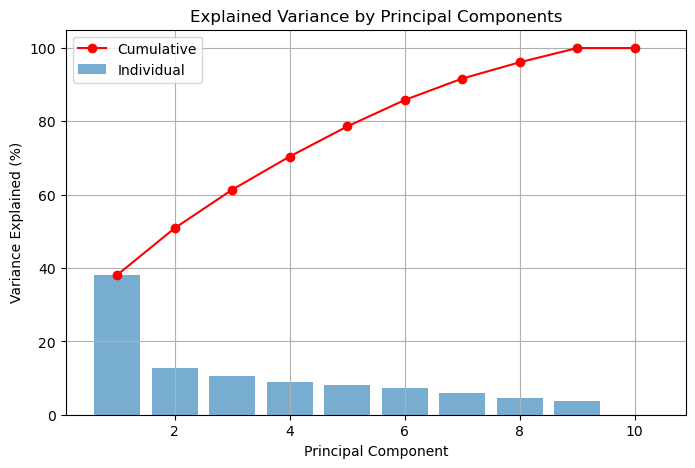

<Figure size 640x480 with 0 Axes>

In [54]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA on the Z-score matrix
pca = PCA()
pca.fit(log_transformed_data.T)  # Transpose so samples are rows

# Get explained variance ratio
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to percentage
cumulative_variance = np.cumsum(explained_variance)  # Cumulative sum
print(f"cumulative_variance: {cumulative_variance}")

# Plot explained variance
plt.figure(figsize=(8,5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label="Individual")
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='r', label="Cumulative")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.title("Explained Variance by Principal Components")
plt.legend()
plt.grid()
plt.show()
plt.savefig("./data/outputs/multiomic/explained_variance_pca_v1.png")

In [56]:
# Transpose data so that samples are rows and features are columns
data_transposed = log_transformed_data.T

# Perform PCA (2 components)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_transposed)

# Merge PCA results with metadata for labeling
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=data_transposed.index)
pca_df = pca_df.merge(metadata_df[['Pig', 'Treatment']], left_index=True, right_on='Pig')

# Plotting PCA scatter plot with group coloring
fig = px.scatter(
    pca_df, x="PC1", y="PC2", color="Treatment", text="Pig",
    title=f"PCA (2D) of Weighted Combined Data: PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%) vs PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)",
    labels={"PC1": "PC1", "PC2": "PC2"},
    template="plotly_white"
)
fig.update_traces(textposition='top center')
fig.show()
fig.write_html("./data/outputs/multiomic/pca_2d_v1.html")
fig.write_image("./data/outputs/multiomic/pca_2d_v1.png")

* To me it seems as if the control/sham group and the treament groups are really well segregated. And we can even use 1 PC to explain the difference. In fact with PC2 things are less clear.
* Also the treatment groups show partial overlap
* Pig 5 again is an outlier


##### Loading weights analysis

In [70]:
# Perform PCA on the Z-score matrix
pca = PCA()
pca.fit(log_transformed_data.T)  # Transpose so samples are rows

# Get the loading weights (PC coefficients)
loading_weights = pd.DataFrame(pca.components_.T, index=log_transformed_data.index, columns=[f'PC{i+1}' for i in range(10)])

# # Sort features by absolute loading in PC1
sorted_features = loading_weights.reindex(loading_weights['PC1'].abs().sort_values(ascending=True).index)

# Absolute values for better visualization
sorted_loading_abs = sorted_features.abs()

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=sorted_loading_abs.values,
    x=sorted_loading_abs.columns,
    y=sorted_loading_abs.index,
    colorscale='Magma',
    colorbar_title="Loading Weight",
    zmin=0, zmax=0.25
))

fig.update_layout(
    title="Heatmap of PCA Loading Weights - sorted by PC1",
    xaxis_title="Principal Component",
    yaxis_title="Feature (Gene or Microbe)"
)

# Show the plot
fig.show()
fig.write_html("./data/outputs/multiomic/pca_loading_weights_PC1_sort.html")
fig.write_image("./data/outputs/multiomic/pca_loading_weights_PC1_sort.png")

#Now PC2
sorted_features = loading_weights.reindex(loading_weights['PC2'].abs().sort_values(ascending=True).index)

# Absolute values for better visualization
sorted_loading_abs = sorted_features.abs()

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=sorted_loading_abs.values,
    x=sorted_loading_abs.columns,
    y=sorted_loading_abs.index,
    colorscale='Magma',
    colorbar_title="Loading Weight",
    zmin=0, zmax=0.25
))

fig.update_layout(
    title="Heatmap of PCA Loading Weights - sorted by PC2",
    xaxis_title="Principal Component",
    yaxis_title="Feature (Gene or Microbe)"
)

# Show the plot
fig.show()
fig.write_html("./data/outputs/multiomic/pca_loading_weights_PC2_sort.html")
fig.write_image("./data/outputs/multiomic/pca_loading_weights_PC2_sort.png")

Now we have a combination of microbes and transcripts that are contributing to both which indicates that the merge is correct. Very nice and promising.

In [73]:
#Export the loading weights to a CSV file
loading_weights.to_csv("./data/outputs/multiomic/pca_loading_weights_v1.csv")

###### Isolate the key features contributing to PCs 1 and 2

In [81]:
#Extract keey features
magnitude_threshold = 0.05

top_pc1_features = loading_weights['PC1'].abs() > magnitude_threshold
top_pc2_features = loading_weights['PC2'].abs() > magnitude_threshold

print(f"Number of features with loading weight > {magnitude_threshold} for PC1: {top_pc1_features.sum()}")
print(f"Number of features with loading weight > {magnitude_threshold} for PC2: {top_pc2_features.sum()}")

top_pc1_loading = loading_weights[top_pc1_features]
top_pc2_loading = loading_weights[top_pc2_features]

top_pc1_loading.to_csv("./data/outputs/multiomic/top_pc1_loading_weights_v1.csv")
top_pc2_loading.to_csv("./data/outputs/multiomic/top_pc2_loading_weights_v1.csv")

Number of features with loading weight > 0.05 for PC1: 49
Number of features with loading weight > 0.05 for PC2: 78


### Hierarchical clustering

In [82]:
# Perform hierarchical clustering on genes (rows)
row_linkage = sch.linkage(dist.pdist(log_transformed_data, metric="euclidean"), method="ward")
row_dendro = sch.dendrogram(row_linkage, no_plot=True)
row_order = row_dendro['leaves']

# Perform hierarchical clustering on samples (columns)
col_linkage = sch.linkage(dist.pdist(log_transformed_data.T, metric="euclidean"), method="ward")
col_dendro = sch.dendrogram(col_linkage, no_plot=True)
col_order = col_dendro['leaves']
display(log_transformed_data.describe())
# Reorder the dataframe based on clustering results
clustered_df = log_transformed_data.iloc[row_order, :]

# Create an interactive heatmap
fig = px.imshow(
    clustered_df, 
    labels=dict(x="Samples", y="Genes", color="Expression Level"),
    color_continuous_scale="RdBu_r",  # Blue = low, Red = high expression
    zmin=-6.5, zmax=6.5,  # Adjust this range if needed for better visualization
    aspect="auto"
)

fig.update_layout(
    title="Hierarchical Clustering Heatmap (Plotly)",
    xaxis_title="Samples",
    yaxis_title="Genes",
    width=1000,
    height=800
)

fig.show()

# Create an interactive heatmap
fig = px.imshow(
    clustered_df, 
    labels=dict(x="Samples", y="Genes", color="Expression Level"),
    color_continuous_scale="RdBu_r",  # Blue = low, Red = high expression
    zmin=-1, zmax=1,  # Adjust this range if needed for better visualization
    aspect="auto"
)

fig.update_layout(
    title="Hierarchical Clustering Heatmap (Plotly)",
    xaxis_title="Samples",
    yaxis_title="Genes",
    width=1000,
    height=800
)

fig.show()
fig.write_html("./data/outputs/multiomic/clustered_multiomic_heatmap_v1.html")
fig.write_image("./data/outputs/multiomic/clustered_multiomic_heatmap_v1.png")

# fig.write_html("./data/outputs/rnaseq/heatmap_plotly.html")
# print("Heatmap saved as HTML!")

# # Save the clustered dataframe
# z_score_df.to_csv("./data/outputs/rnaseq/z_score_df.csv", index=True)

,PIG1,PIG2,PIG3,PIG5,PIG6,PIG7,PIG9,PIG10,PIG11,PIG12
count,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000
mean,0.018310,0.037874,-0.020676,0.065156,0.060937,0.115238,0.096450,0.107675,0.079513,0.094827
std,0.517744,0.521964,0.539009,0.743412,0.870336,0.999814,0.904528,0.985068,0.879779,0.963317
min,-1.932934,-2.063628,-2.080778,-1.774090,-1.654236,-1.568366,-1.660153,-1.700836,-1.689209,-1.750758
25%,-0.346618,-0.304526,-0.379039,-0.320294,-0.338857,-0.350177,-0.334285,-0.334882,-0.321211,-0.335180
50%,0.106733,0.025167,0.062239,0.059618,0.031607,0.073263,0.059763,0.046100,0.057892,0.016737
75%,0.342865,0.353114,0.305832,0.357714,0.355848,0.362464,0.369910,0.359631,0.329548,0.365793
max,1.897035,2.027486,2.022608,6.680047,6.540053,6.533106,6.421751,6.339337,6.406728,6.523857
